In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import input_data, signal, datasets, image, plotting
import nilearn
from nilearn.regions import connected_label_regions
#from templateflow import api
from bct import distance_wei, modularity_louvain_und

import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os
import pickle

In [2]:
def get_folders(path):
    """Gets all folders within a specified path."""
    folders = []
    for entry in os.scandir(path):
        if entry.is_dir():
            folders.append(entry.name)
    return folders

In [3]:
def load_and_prepare_data(bold_files, confounds_files, difumo_atlas):
    """
    Load and prepare BOLD data using the DiFuMo probabilistic atlas

    Parameters:
    -----------
    bold_files : list of str
        Paths to preprocessed BOLD data for each subject/session
    confounds_files : list of str
        Paths to confound regressors from fMRIprep
    difumo_atlas : str or NiftiImage
        Path to DiFuMo probabilistic atlas or loaded atlas image
    target_roi_indices : list of int
        Indices of ROIs in target region (subgenual ACC)

    Returns:
    --------
    time_series_dict : dict
        Dictionary containing cleaned time series for each subject/condition
    """
    # Use NiftiMapsMasker instead of NiftiLabelsMasker for probabilistic atlas
    masker = input_data.NiftiMapsMasker(
        maps_img=difumo_atlas,
        standardize=True,
        detrend=False,
        low_pass=0.1,
        high_pass=0.01,
        t_r=1.0,
        memory='nilearn_cache',  # Cache computations
        memory_level=1,
        verbose=1
    )

    time_series_dict = {
        'active': [],
        'sham': []
    }

    for bold_file, confound_file in zip(bold_files, confounds_files):
        # Load confounds
        confounds = pd.read_csv(confound_file, sep='\t')

        # Select specific confound regressors
        selected_confounds = pd.concat([
            # Motion parameters and their derivatives/quadratic terms
            #confounds.filter(regex='^(trans|rot)_(x|y|z)($|_derivative1$|_power2$)'),
            confounds.filter(regex='^(trans|rot)_(x|y|z)($|_derivative1$)'),

            # CompCor components
            #confounds.filter(regex='^[at]_comp_cor_\d+'),

            # Global signals
            #confounds[['csf', 'white_matter', 'global_signal']],

            # Motion outliers
            #confounds.filter(regex='^motion_outlier'),

            # Edge/crown signals
            #confounds.filter(regex='^edge_')
        ], axis=1)

        # remove any columns in selected_confounds that have nans
        selected_confounds = selected_confounds.dropna(axis=1)

        # Extract time series with confound regression
        # This will now return time series for each probabilistic component
        time_series = masker.fit_transform(bold_file, confounds=selected_confounds)

        # Sort into conditions
        if 'ACTIVE' in bold_file:
            time_series_dict['active'].append(time_series)
        else:
            time_series_dict['sham'].append(time_series)

    return time_series_dict

In [4]:
def load_difumo_atlas(atlas_path):
    """
    Load DiFuMo atlas and verify its dimensions

    Parameters:
    -----------
    atlas_path : str
        Path to the DiFuMo atlas file

    Returns:
    --------
    atlas_img : Nifti1Image
        Loaded atlas image
    """
    from nilearn import image

    atlas_img = image.load_img(atlas_path)

    # Verify this is a 4D image with 1024 components
    if atlas_img.ndim != 4:
        raise ValueError("Expected 4D atlas image")
    if atlas_img.shape[-1] != 1024:
        raise ValueError(f"Expected 1024 components, got {atlas_img.shape[-1]}")

    return atlas_img

In [5]:
def analyze_immediate_effects(time_series_dict, stim_onsets, pre_stim=5, post_stim=60, baseline_correct=True):
    """
    Analyze immediate effects of stimulation using event-related averaging

    Parameters:
    -----------
    time_series_dict : dict
        Dictionary containing time series data
    stim_onsets : array-like
        Stimulus onset times in TRs
    target_roi_indices : list of int
        Indices of target ROIs

    Returns:
    --------
    results_dict : dict
        Dictionary containing statistical results
    """
    results_dict = {}

    # Define time window for analysis (e.g., -5 to +15 TRs around stim)

    all_responses = {'active': [], 'sham': []}

    for condition in ['active', 'sham']:
        for subj_data in time_series_dict[condition]:
            # Extract epochs around each stimulus
            epochs = []
            for onset in stim_onsets:
            
                epoch = subj_data[onset-pre_stim:onset+post_stim, :]
                # remove baseline
                if baseline_correct:
                    baseline = subj_data[onset-pre_stim:onset, :]
                    epoch = epoch - np.mean(baseline, axis=0)
                if epoch.shape[0] == (pre_stim + post_stim):
                    epochs.append(epoch)
                    #epochs.append(epoch[pre_stim:,:])

            # Average across epochs for this subject
            subj_response = np.mean(epochs, axis=0)
            all_responses[condition].append(subj_response)

            #all_responses.append(subj_response)

        # Convert to array
        all_responses[condition] = np.array(all_responses[condition])

    return all_responses

In [6]:
generate_time_series = False

In [7]:
if generate_time_series:
    ## Generate a list of all available bold records from both ACTIVE and SHAM sessions
    data_root = '/Users/jacekdmochowski/PROJECTS/fus/data/resampled_bold_flywheel/'
    # list all folders in data_root
    folders = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))]
    bold_files = []
    confounds_files = []
    for folder in folders:
        # find file in output_folder that contains 'preproc_bold_resampled'
        output_folder = os.listdir(os.path.join(os.path.join(data_root,folder),'output'))
        for file in output_folder:
            if 'preproc_bold_resampled' in file:
                bold_files.append(os.path.join(os.path.join(data_root,folder),'output',file))
    
        # confounds timeseries
        input_folder=os.path.join(os.path.join(data_root,folder),'input')
        tmp=get_folders(os.path.join(os.path.join(data_root,folder),'input'))[0]
        tmp2=[x for x in get_folders(os.path.join(input_folder,tmp)) if 'sub-' in x]
        tmp3=os.path.join(os.path.join(input_folder,tmp),tmp2[0])
        tmp4=[os.path.join(tmp3,x) for x in os.listdir(tmp3) if 'ses-' in x][0]
        tmp5=[os.path.join(tmp4,x) for x in os.listdir(tmp4) if 'func' in x][0]
        confounds_files.append([os.path.join(tmp5,x) for x in os.listdir(tmp5) if 'confounds_timeseries.tsv' in x][0])
    
    print(f"Found {len(bold_files)} bold files")
    print(f"Found {len(confounds_files)} confounds files")

In [8]:
if generate_time_series:
    path_to_difumo = '/Users/jacekdmochowski/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_atlas-DiFuMo_desc-1024dimensions_probseg.nii.gz'
    try:
        difumo_atlas = load_difumo_atlas(path_to_difumo)
    except ValueError as e:
        print(f"Error loading DiFuMo atlas: {e}")
        print("Attempting to download from TemplateFlow")
        if path_to_difumo is None:
            path_to_difumo = api.get('MNI152NLin2009cAsym', atlas="DiFuMo", desc="1024dimensions", resolution=2, suffix="probseg", extension="nii.gz")
        difumo_atlas = nib.load(path_to_difumo)

In [9]:
if generate_time_series:
    time_series = load_and_prepare_data(bold_files, confounds_files, difumo_atlas)
    with open('../data/precomputed/difumo_time_series.pkl', 'wb') as f:
        pickle.dump(time_series, f)
else:
    with open('../data/precomputed/difumo_time_series.pkl', 'rb') as f:
        time_series = pickle.load(f)

## Time course of mean BOLD


In [10]:
bold_3d_active = np.array(time_series['active'])
bold_3d_sham = np.array(time_series['sham'])

idx_pre = range(100,300)
idx_fus = range(300,600)
idx_post = range(600,900)

mu_active_pre = np.mean(bold_3d_active[:,idx_pre,:], axis=1)
mu_active_fus = np.mean(bold_3d_active[:,idx_fus,:], axis=1)
mu_active_post = np.mean(bold_3d_active[:,idx_post,:], axis=1)

mu_sham_pre = np.mean(bold_3d_sham[:,idx_pre,:], axis=1)
mu_sham_fus = np.mean(bold_3d_sham[:,idx_fus,:], axis=1)
mu_sham_post = np.mean(bold_3d_sham[:,idx_post,:], axis=1)

sigma_active_pre = np.std(bold_3d_active[:,idx_pre,:], axis=1)
sigma_active_fus = np.std(bold_3d_active[:,idx_fus,:], axis=1)
sigma_active_post = np.std(bold_3d_active[:,idx_post,:], axis=1)

sigma_sham_pre = np.std(bold_3d_sham[:,idx_pre,:], axis=1)
sigma_sham_fus = np.std(bold_3d_sham[:,idx_fus,:], axis=1)
sigma_sham_post = np.std(bold_3d_sham[:,idx_post,:], axis=1)


In [11]:
del_mu_active = 2*(mu_active_fus - mu_active_pre) / (sigma_active_pre + sigma_active_fus)
del_mu_sham = 2*(mu_sham_fus - mu_sham_pre) / (sigma_sham_pre + sigma_sham_fus)
del_mu_active_post = 2*(mu_active_post - mu_active_pre) / (sigma_active_pre + sigma_active_post)
del_mu_sham_post = 2*(mu_sham_post - mu_sham_pre) / (sigma_sham_pre + sigma_sham_post)

del_sigma_active = 2* (sigma_active_fus - sigma_active_pre) / (sigma_active_pre + sigma_active_fus)
del_sigma_sham = 2*(sigma_sham_fus - sigma_sham_pre) / (sigma_sham_pre + sigma_sham_fus)
del_sigma_active_post = 2*(sigma_active_post - sigma_active_pre) / (sigma_active_pre + sigma_active_post)
del_sigma_sham_post = 2*(sigma_sham_post - sigma_sham_pre) / (sigma_sham_post + sigma_sham_pre)


In [12]:
t_stats_mu = []
pvals_mu = []

t_stats_sigma = []
pvals_sigma = []

t_stats_mu_post = []
pvals_mu_post = []

t_stats_sigma_post = []
pvals_sigma_post = []

for roi in range(1024):
    t_stat, p_val = stats.ttest_rel(del_mu_active[:,roi], del_mu_sham[:,roi])
    #t_stat, p_val = stats.wilcoxon(del_mu_active[:,roi], del_mu_sham[:,roi])
    t_stats_mu.append(t_stat)
    pvals_mu.append(p_val)
    
    t_stat, p_val = stats.ttest_rel(del_mu_active_post[:,roi], del_mu_sham_post[:,roi])
    #t_stat, p_val = stats.wilcoxon(del_mu_active_post[:,roi], del_mu_sham_post[:,roi])
    t_stats_mu_post.append(t_stat)
    pvals_mu_post.append(p_val)
    
    t_stat, p_val = stats.ttest_rel(del_sigma_active[:,roi], del_sigma_sham[:,roi])
    #t_stat, p_val = stats.wilcoxon(del_sigma_active[:,roi], del_sigma_sham[:,roi])
    t_stats_sigma.append(t_stat)
    pvals_sigma.append(p_val)
    
    t_stat, p_val = stats.ttest_rel(del_sigma_active_post[:,roi], del_sigma_sham_post[:,roi])
    #t_stat, p_val = stats.wilcoxon(del_sigma_active_post[:,roi], del_sigma_sham_post[:,roi])
    t_stats_sigma_post.append(t_stat)
    pvals_sigma_post.append(p_val)
    


In [13]:
rois_sig_mu = np.where(np.array(pvals_mu)<0.05)[0]
rois_sig_sigma = np.where(np.array(pvals_sigma)<0.05)[0]
rois_sig_mu_post = np.where(np.array(pvals_mu_post)<0.05)[0]
rois_sig_sigma_post =  np.where(np.array(pvals_sigma_post)<0.05)[0]

print(f"The number of significant ROIs for mean active vs sham is {len(rois_sig_mu)}")
print(f"The number of significant ROIs for sigma active vs sham is {len(rois_sig_sigma)}")
print(f"The number of significant ROIs for mean active vs sham post is {len(rois_sig_mu_post)}")
print(f"The number of significant ROIs for sigma active vs sham post is {len(rois_sig_sigma_post)}")


The number of significant ROIs for mean active vs sham is 104
The number of significant ROIs for sigma active vs sham is 37
The number of significant ROIs for mean active vs sham post is 57
The number of significant ROIs for sigma active vs sham post is 22


In [14]:
np.min(pvals_mu), np.min(pvals_mu_post), np.min(pvals_sigma), np.min(pvals_sigma_post)

(7.363032122132046e-05,
 0.0011253091715028858,
 0.0016935975409403203,
 0.0004740148301178619)

In [15]:
# correct for multiple comparisons
pvals_fdr_mu = multipletests(pvals_mu, alpha=0.05, method='fdr_bh')[1]
pvals_fdr_mu_post = multipletests(pvals_mu_post, alpha=0.05, method='fdr_bh')[1]
pvals_fdr_sigma = multipletests(pvals_sigma, alpha=0.05, method='fdr_bh')[1]
pvals_fdr_sigma_post = multipletests(pvals_sigma_post, alpha=0.05, method='fdr_bh')[1]
np.min(pvals_fdr_mu), np.min(pvals_fdr_mu_post), np.min(pvals_fdr_sigma), np.min(pvals_fdr_sigma_post)

(0.07539744893063215,
 0.5268705031537018,
 0.976139136445321,
 0.4853911860406906)

In [16]:
# load DiFuMo atlas
difumo = datasets.fetch_atlas_difumo(dimension=1024)
labels = difumo.labels  # List of 1024 anatomical labels
atlas_img = nib.load(difumo.maps)
labels[rois_sig_sigma_post]

rec.array([(  93, 'Posterior corona radiata RH', 'No network found', 'No network found', 0.02890973, 0.97104268, 4.85273314e-05),
           ( 123, 'Middle temporal gyrus middle LH', 'DefaultB', 'DefaultB', 0.77103717, 0.1719479 , 5.35272434e-02),
           ( 170, 'Cerebellum VI', 'No network found', 'No network found', 0.83012995, 0.11188682, 5.68678706e-02),
           ( 227, 'Uncinate fasciculus anterior', 'LimbicA', 'LimbicB', 0.2314617 , 0.76471722, 3.82899461e-03),
           ( 301, 'Superior frontal gyrus middle', 'SalVentAttnA', 'SalVentAttnB', 0.5798347 , 0.35035305, 6.04395361e-02),
           ( 411, 'Cerebellum Vermis IX', 'No network found', 'No network found', 0.81979759, 0.08423758, 9.59663011e-02),
           ( 440, 'Cerebrospinal fluid (between superior frontal gyrus mid-posterior and skull LH)', 'DefaultB', 'DefaultB', 0.58675263, 0.06195708, 1.02153874e-01),
           ( 454, 'Internal capsule anterior limb RH', 'No network found', 'No network found', 0.03183745, 0.9

In [17]:
# Create volume with variability values
# Assuming variability_values is your 1024-length array of variability metrics
variability_map = np.zeros(atlas_img.shape[:-1])
for roi_idx in range(1024):
    roi_mask = (atlas_img.get_fdata()[:,:,:,roi_idx] > 0)
    variability_map[roi_mask] = t_stats_mu[roi_idx]
    #variability_map[roi_mask] = t_stats_mu_post[roi_idx]
    #variability_map[roi_mask] = t_stats_sigma[roi_idx]
    #variability_map[roi_mask] = t_stats_sigma_post[roi_idx]
    #variability_map[roi_mask] = pvals_sigma_post[roi_idx] < 0.01
    
# Create and save NIfTI
variability_nii = nib.Nifti1Image(variability_map, atlas_img.affine)


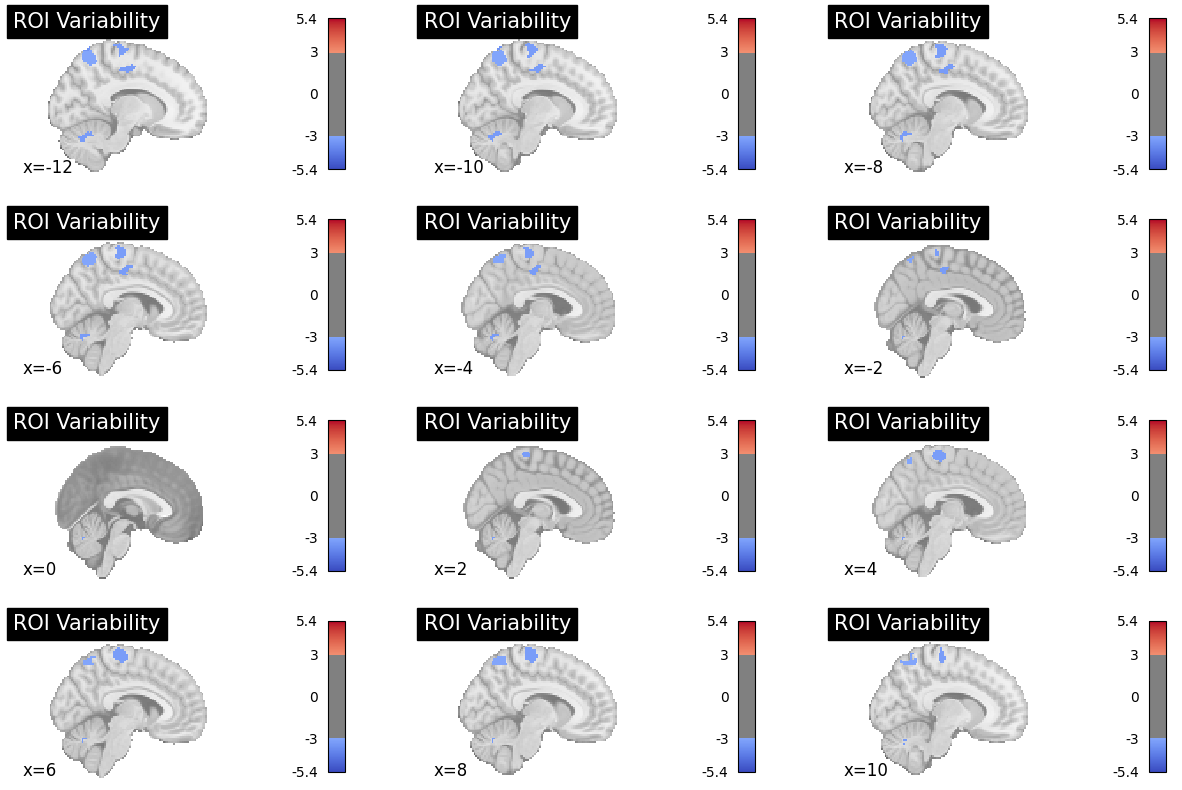

In [18]:
fig, ax = plt.subplots(4,3, figsize=(15,10))

# Plot
for i, x in enumerate(range(-12, 12, 2)):
    
    # convert i to a row column index
    row = i // 3
    col = i % 3
    
    plotting.plot_stat_map(variability_nii,
                          title='ROI Variability',
                          colorbar=True,
                          display_mode='x',
                          cut_coords=range(x, x+1, 2),
                          cmap = 'coolwarm',
                          threshold=3.,
                           figure=fig, axes=ax[row,col])

In [19]:
difumo = datasets.fetch_atlas_difumo(dimension=1024)
labels = difumo.labels  # List of 1024 anatomical labels
labels[np.where(np.array(t_stats_sigma_post)<-3)]

rec.array([(454, 'Internal capsule anterior limb RH', 'No network found', 'No network found', 0.03183745, 0.9644425 , 0.00372936),
           (576, 'Intraparietal sulcus superior RH', 'DorsAttnB', 'DorsAttnA', 0.46611797, 0.09539007, 0.23201533)],
          dtype=[('component', '<i8'), ('difumo_names', 'O'), ('yeo_networks7', 'O'), ('yeo_networks17', 'O'), ('gm', '<f8'), ('wm', '<f8'), ('csf', '<f8')])

In [20]:
labels [ np.where ( np.array(t_stats_sigma_post) < -4 ) ]

rec.array([],
          dtype=[('component', '<i8'), ('difumo_names', 'O'), ('yeo_networks7', 'O'), ('yeo_networks17', 'O'), ('gm', '<f8'), ('wm', '<f8'), ('csf', '<f8')])

## Functional connectivity analysis

In [21]:
for s in range(bold_3d_active.shape[0]):
    bold_3d_active[s,:,:] = signal.clean(bold_3d_active[s,:,:], detrend=False, standardize=False)
    bold_3d_sham[s,:,:] = signal.clean(bold_3d_sham[s,:,:], detrend=False, standardize=False)
    
    # compute functional connectivity matrix for this subject and condition
    corrmat_active_pre = np.corrcoef(bold_3d_active[s,idx_pre,:].T)
    corrmat_active_fus = np.corrcoef(bold_3d_active[s,idx_fus,:].T)
    corrmat_active_post = np.corrcoef(bold_3d_active[s,idx_post,:].T)
    
    corrmat_sham_pre = np.corrcoef(bold_3d_sham[s,idx_pre,:].T)
    corrmat_sham_fus = np.corrcoef(bold_3d_sham[s,idx_fus,:].T)
    corrmat_sham_post = np.corrcoef(bold_3d_sham[s,idx_post,:].T)
    
    if s == 0:
        all_corrmat_active_pre = corrmat_active_pre
        all_corrmat_active_fus = corrmat_active_fus
        all_corrmat_active_post = corrmat_active_post
        
        all_corrmat_sham_pre = corrmat_sham_pre
        all_corrmat_sham_fus = corrmat_sham_fus
        all_corrmat_sham_post = corrmat_sham_post
        
    else:
        all_corrmat_active_pre = np.dstack((all_corrmat_active_pre, corrmat_active_pre))
        all_corrmat_active_fus = np.dstack((all_corrmat_active_fus, corrmat_active_fus))
        all_corrmat_active_post = np.dstack((all_corrmat_active_post, corrmat_active_post))
        
        all_corrmat_sham_pre = np.dstack((all_corrmat_sham_pre, corrmat_sham_pre))
        all_corrmat_sham_fus = np.dstack((all_corrmat_sham_fus, corrmat_sham_fus))
        all_corrmat_sham_post = np.dstack((all_corrmat_sham_post, corrmat_sham_post))
        

Text(0.5, 1.0, 'Sham Post - Pre')

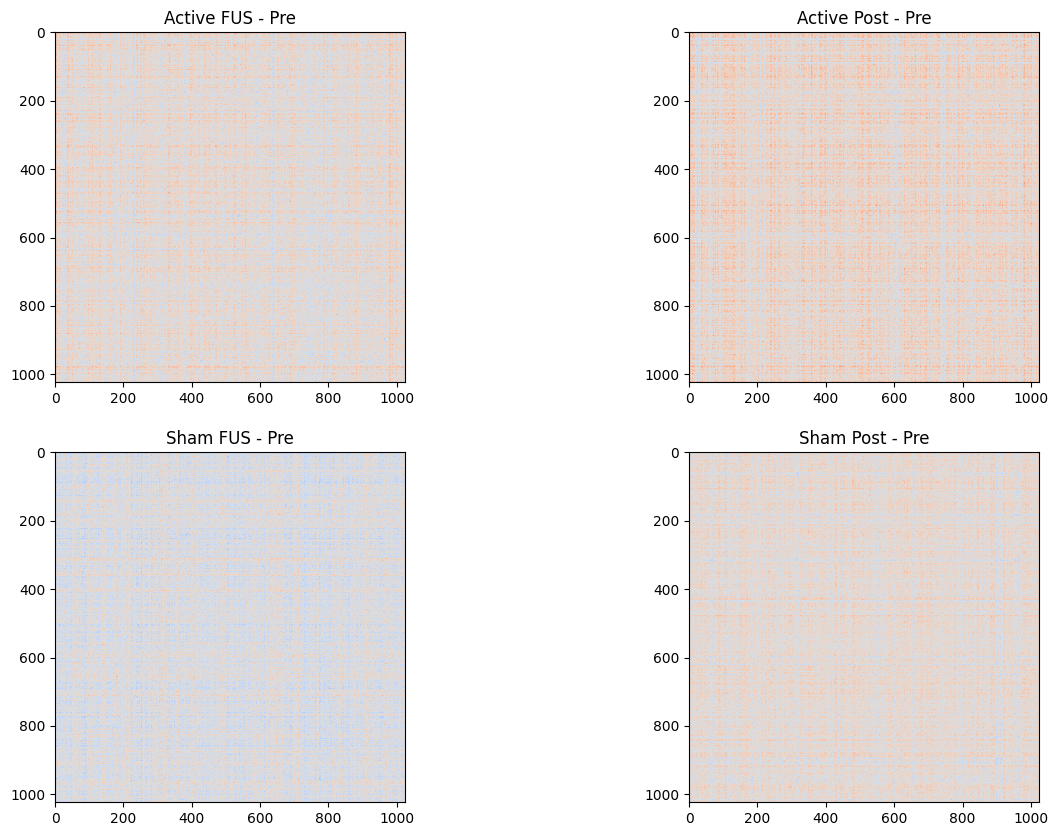

In [22]:
# display the averaged fc matrices before during and at the end of stimulation
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Active
ax[0, 0].imshow( np.mean(all_corrmat_active_fus, axis=2) - np.mean(all_corrmat_active_pre, axis=2) , cmap='coolwarm', vmin=-.2, vmax=.2)
ax[0, 0].set_title('Active FUS - Pre')

ax[0, 1].imshow(np.mean(all_corrmat_active_post, axis=2) - np.mean(all_corrmat_active_pre, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
ax[0, 1].set_title('Active Post - Pre')

#ax[0, 2].imshow(np.mean(all_corrmat_active_post, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
#ax[0, 2].set_title('Active Post')

# Sham
ax[1, 0].imshow(np.mean(all_corrmat_sham_fus, axis=2) - np.mean(all_corrmat_sham_pre, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
ax[1, 0].set_title('Sham FUS - Pre')

ax[1, 1].imshow(np.mean(all_corrmat_sham_post, axis=2) - np.mean(all_corrmat_sham_fus, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
ax[1, 1].set_title('Sham Post - Pre')

#ax[1, 2].imshow(np.mean(all_corrmat_sham_post, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
#ax[1, 2].set_title('Sham Post')



(array([6.0000e+00, 4.0000e+00, 2.0000e+00, 1.2000e+01, 8.0000e+00,
        1.6000e+01, 1.8000e+01, 3.0000e+01, 4.2000e+01, 6.0000e+01,
        8.2000e+01, 1.2400e+02, 1.7000e+02, 2.4200e+02, 3.3800e+02,
        4.5600e+02, 5.8200e+02, 7.2000e+02, 9.8200e+02, 1.3280e+03,
        1.6920e+03, 2.1400e+03, 2.7260e+03, 3.3000e+03, 4.2980e+03,
        4.9320e+03, 6.0980e+03, 7.6120e+03, 8.5960e+03, 1.0422e+04,
        1.1868e+04, 1.3854e+04, 1.5902e+04, 1.8032e+04, 2.0200e+04,
        2.2592e+04, 2.4684e+04, 2.6994e+04, 2.9230e+04, 3.1138e+04,
        3.3176e+04, 3.5350e+04, 3.6256e+04, 3.7614e+04, 3.8894e+04,
        3.9720e+04, 3.9860e+04, 3.9710e+04, 3.9590e+04, 3.8630e+04,
        3.6962e+04, 3.5612e+04, 3.4208e+04, 3.2598e+04, 3.0188e+04,
        2.7838e+04, 2.5254e+04, 2.3394e+04, 2.1306e+04, 1.9176e+04,
        1.6832e+04, 1.4854e+04, 1.2922e+04, 1.0998e+04, 9.8400e+03,
        8.3280e+03, 6.9500e+03, 5.8720e+03, 4.8940e+03, 3.9540e+03,
        3.1520e+03, 2.5360e+03, 2.2040e+03, 1.73

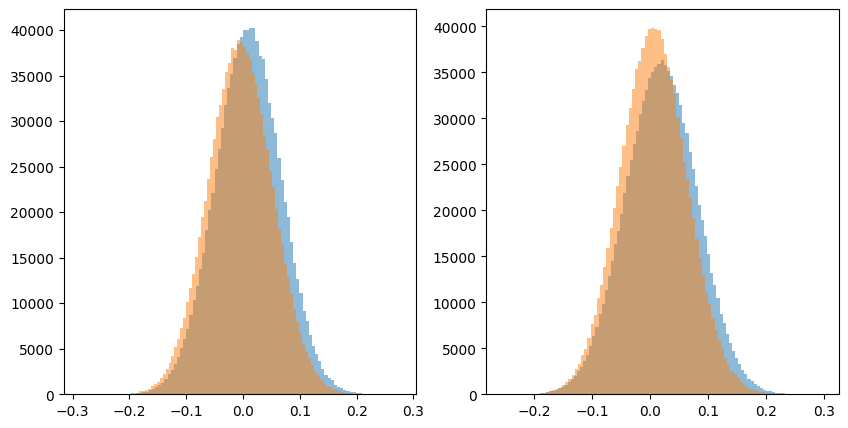

In [23]:
dels_active = np.mean(all_corrmat_active_fus - all_corrmat_active_pre, axis=2)
dels_sham = np.mean(all_corrmat_sham_fus - all_corrmat_sham_pre, axis=2)
dels_active_post = np.mean(all_corrmat_active_post - all_corrmat_active_pre, axis=2)
dels_sham_post = np.mean(all_corrmat_sham_post - all_corrmat_sham_pre, axis=2)

# remove all diagonal elements from dels_active and dels_sham
for i in range(dels_active.shape[0]):
    dels_active[i,i] = np.nan
    dels_sham[i,i] = np.nan
    
    dels_active_post[i,i] = np.nan
    dels_sham_post[i,i] = np.nan
    
# plot a histogram of the differences
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dels_active.flatten(), bins=100, alpha=0.5, label='active')
ax[0].hist(dels_sham.flatten(), bins=100, alpha=0.5, label='sham')

ax[1].hist(dels_active_post.flatten(), bins=100, alpha=0.5, label='active')
ax[1].hist(dels_sham_post.flatten(), bins=100, alpha=0.5, label='sham')
#plt.legend()

In [24]:
t1 = np.mean(all_corrmat_active_pre, axis=2)
t1[t1==1] = np.nan

t2 = np.mean(all_corrmat_active_fus, axis=2)
t2[t2==1] = np.nan

t3 = np.mean(all_corrmat_active_post, axis=2)
t3[t3==1] = np.nan

t4 = np.mean(all_corrmat_sham_pre, axis=2)
t4[t4==1] = np.nan

t5 = np.mean(all_corrmat_sham_fus, axis=2)
t5[t5==1] = np.nan

t6 = np.mean(all_corrmat_sham_post, axis=2)
t6[t6==1] = np.nan

np.nanmean(t1), np.nanmean(t2), np.nanmean(t3), np.nanmean(t4), np.nanmean(t5), np.nanmean(t6), np.nanmean(t2-t1), np.nanmean(t3-t1), np.nanmean(t5-t4), np.nanmean(t6-t4)

(0.10666126541250118,
 0.11577850110230141,
 0.12557088912935652,
 0.13408929708317296,
 0.1295188111207583,
 0.1398783878030835,
 0.009114781769254473,
 0.018896430406012042,
 -0.004567205724397,
 0.005781756283431488)

In [25]:
# for each connection, compute the p-value between dels_active and dels_sham
dels_active = all_corrmat_active_fus - all_corrmat_active_pre
dels_sham = all_corrmat_sham_fus - all_corrmat_sham_pre

dels_active_post = all_corrmat_active_post - all_corrmat_active_pre
dels_sham_post = all_corrmat_sham_post - all_corrmat_sham_pre

t_stats = []
p_vals = []

t_stats_post = []
p_vals_post = []

for i in range(dels_active.shape[0]):
    for j in range(i+1, dels_active.shape[1]):
        t_stat, p_val = stats.ttest_rel(dels_active[i,j,:], dels_sham[i,j,:])
        
        # use wilcoxon test
        #t_stat, p_val = stats.wilcoxon(dels_active[i,j,:], dels_sham[i,j,:])
        t_stats.append(t_stat)
        p_vals.append(p_val)

        t_stat_post, p_val_post = stats.ttest_rel(dels_active_post[i,j,:], dels_sham_post[i,j,:])
        #t_stat_post, p_val_post = stats.wilcoxon(dels_active_post[i,j,:], dels_sham_post[i,j,:])
        t_stats_post.append(t_stat_post)
        p_vals_post.append(p_val_post)
        
    

In [26]:
# perform FDR on the pvals
tmp = multipletests(p_vals, alpha=0.05, method='fdr_bh')

In [27]:
np.min(tmp[1]), np.sum(tmp[1]<0.05)

(0.18037645587875917, 0)

In [28]:
np.min(p_vals), np.min(p_vals_post)#, np.mean(pvals_fdr)

(5.788324805244169e-07, 8.666401497983607e-06)

In [29]:
import numpy as np
from nilearn import datasets

# Load DiFuMo atlas
atlas = nilearn.datasets.fetch_atlas_difumo(dimension=1024, resolution_mm=2)
atlas_img = nib.load(atlas.maps)


# Get coordinates of ROI 133 (subgenual ACC)
sgacc_data = atlas_img.get_fdata()[:,:,:,133]  # 0-based indexing
sgacc_coords = np.where(sgacc_data > 0)

# Function to calculate distance between ROI centers
def get_roi_center(roi_data):
    coords = np.where(roi_data > 0)
    if len(coords[0]) == 0:
        return None
    return np.array([np.mean(coords[0]), np.mean(coords[1]), np.mean(coords[2])])

sgacc_center = get_roi_center(sgacc_data)

# Find nearby ROIs
distances = []
for i in range(atlas_img.shape[-1]):
    roi_data = atlas_img.get_fdata()[:,:,:,i]
    roi_center = get_roi_center(roi_data)
    if roi_center is not None:
        distance = np.linalg.norm(sgacc_center - roi_center)
        distances.append((i+1, distance, labels[i]))  # i+1 for 1-based indexing

# Sort by distance and get closest ROIs
closest = sorted(distances, key=lambda x: x[1])[:10]

print("Closest ROIs to subgenual ACC (ROI 133):")
for roi_num, dist, label in closest:
    if roi_num != 133:  # Skip the ROI itself
        print(f"ROI {roi_num}: {label} (distance: {dist:.2f})")

Closest ROIs to subgenual ACC (ROI 133):
ROI 134: (134, 'Subgenual cortex', 'LimbicA', 'LimbicB', 0.66276582, 0.24776501, 0.08946455) (distance: 0.00)
ROI 227: (227, 'Uncinate fasciculus anterior', 'LimbicA', 'LimbicB', 0.2314617, 0.76471722, 0.00382899) (distance: 3.35)
ROI 486: (486, 'Corpus callosum genu inferior', 'No network found', 'No network found', 0.62412905, 0.29604277, 0.07984084) (distance: 4.04)
ROI 973: (973, 'Suborbital sulcus', 'DefaultB', 'DefaultA', 0.50576346, 0.47347792, 0.02077083) (distance: 5.07)
ROI 62: (62, 'Ventromedial prefrontal cortex posterior ', 'LimbicA', 'LimbicB', 0.75770921, 0.15468042, 0.08760688) (distance: 5.32)
ROI 710: (710, 'Posterior orbital gyrus posterior', 'DefaultB', 'DefaultB', 0.68129023, 0.07856917, 0.2340474) (distance: 5.93)
ROI 567: (567, 'Anterior insula antero-superior', 'SalVentAttnA', 'SalVentAttnB', 0.84369824, 0.04636382, 0.10992908) (distance: 6.61)
ROI 717: (717, 'Subcallosal cortex superior', 'LimbicA', 'LimbicB', 0.76573217

In [31]:
roi = 133
#roi = 61
print(labels[roi])
t1 = np.mean( (all_corrmat_active_fus[roi,:] - all_corrmat_active_pre[roi,:]) , axis=0)
t2 = np.mean( (all_corrmat_sham_fus[roi,:] - all_corrmat_sham_pre[roi,:]) , axis=0)

t3 = np.mean( (all_corrmat_active_post[roi,:] - all_corrmat_active_pre[roi,:]) , axis=0)
t4 = np.mean( (all_corrmat_sham_post[roi,:] - all_corrmat_sham_pre[roi,:]) , axis=0)
stats.ttest_rel(t1,t2), stats.ttest_rel(t3,t4), labels.shape, atlas_img.get_fdata().shape



(134, 'Subgenual cortex', 'LimbicA', 'LimbicB', 0.66276582, 0.24776501, 0.08946455)


(TtestResult(statistic=2.319691448695094, pvalue=0.03486999430680857, df=15),
 TtestResult(statistic=2.438528933719202, pvalue=0.027657295501637657, df=15),
 (1024,),
 (104, 123, 104, 1024))

In [33]:
t1.shape, t2.shape, t3.shape, t4.shape

((16,), (16,), (16,), (16,))

(-0.25, 0.25)

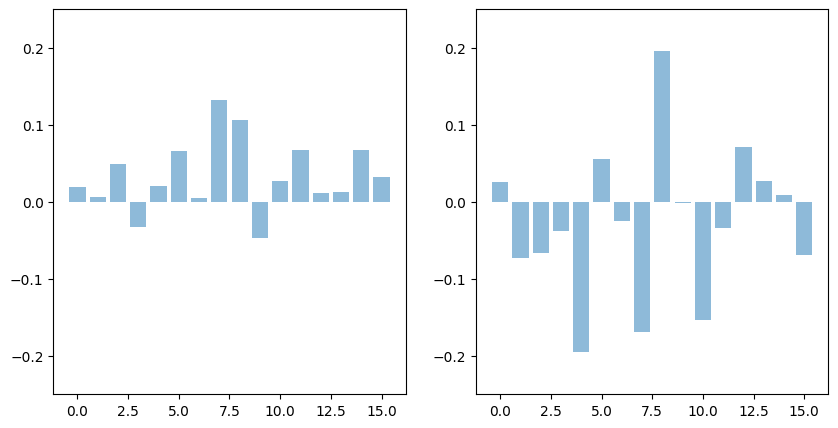

In [34]:
# make a bar plot of t1 vs t2
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(16), t1, alpha=0.5, label='active')
ax[0].set_ylim(-0.25, 0.25)
ax[1].bar(range(16), t2, alpha=0.5, label='sham')
ax[1].set_ylim(-0.25, 0.25)

(-0.25, 0.25)

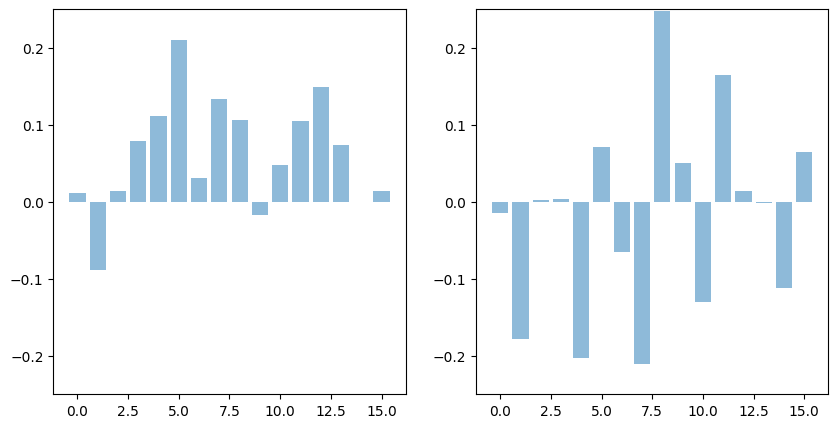

In [35]:
# make a bar plot of t1 vs t2
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(16), t3, alpha=0.5, label='active')
ax[0].set_ylim(-0.25, 0.25)
ax[1].bar(range(16), t4, alpha=0.5, label='sham')
ax[1].set_ylim(-0.25, 0.25)

In [36]:
np.sum(t1>t2), np.sum(t1<t2), np.sum(t3>t4), np.sum(t3<t4)

(11, 5, 12, 4)

In [37]:
winlen = 20 # units in TRs
winshift = 5 # units in TRs
n_wins = int((bold_3d_active.shape[1] - winlen) / winshift) + 1


In [38]:
all_win_corrmat_active = np.nan * np.ones(shape=(n_wins, bold_3d_active.shape[2], bold_3d_active.shape[2]))
all_win_corrmat_sham = np.nan * np.ones(shape=(n_wins, bold_3d_active.shape[2], bold_3d_active.shape[2]))
all_win_corrmat_active.shape, all_win_corrmat_sham.shape

((177, 1024, 1024), (177, 1024, 1024))

In [39]:
wincenters = []
for w in range(n_wins):
    
    idx = range(w*winshift, w*winshift+winlen)
    wincenters.append( w*winshift + winlen//2 )
    print(idx)
    
    for s in range(bold_3d_active.shape[0]):     
    
        # compute functional connectivity matrix for this subject and condition and time window
        cc_active = np.corrcoef(bold_3d_active[s,idx,:].T)     
        cc_sham = np.corrcoef(bold_3d_sham[s,idx,:].T)
    
        if s == 0:
            all_cc_active = cc_active
            all_cc_sham= cc_sham
        else:
            all_cc_active = np.dstack((all_cc_active, cc_active))
            all_cc_sham = np.dstack((all_cc_sham, cc_sham))
    
    all_win_corrmat_active[w,:,:] = np.mean(all_cc_active, axis=2)
    all_win_corrmat_sham[w,:,:] = np.mean(all_cc_sham, axis=2)
        

range(0, 20)
range(5, 25)
range(10, 30)
range(15, 35)
range(20, 40)
range(25, 45)
range(30, 50)
range(35, 55)
range(40, 60)
range(45, 65)
range(50, 70)
range(55, 75)
range(60, 80)
range(65, 85)
range(70, 90)
range(75, 95)
range(80, 100)
range(85, 105)
range(90, 110)
range(95, 115)
range(100, 120)
range(105, 125)
range(110, 130)
range(115, 135)
range(120, 140)
range(125, 145)
range(130, 150)
range(135, 155)
range(140, 160)
range(145, 165)
range(150, 170)
range(155, 175)
range(160, 180)
range(165, 185)
range(170, 190)
range(175, 195)
range(180, 200)
range(185, 205)
range(190, 210)
range(195, 215)
range(200, 220)
range(205, 225)
range(210, 230)
range(215, 235)
range(220, 240)
range(225, 245)
range(230, 250)
range(235, 255)
range(240, 260)
range(245, 265)
range(250, 270)
range(255, 275)
range(260, 280)
range(265, 285)
range(270, 290)
range(275, 295)
range(280, 300)
range(285, 305)
range(290, 310)
range(295, 315)
range(300, 320)
range(305, 325)
range(310, 330)
range(315, 335)
range(320, 340

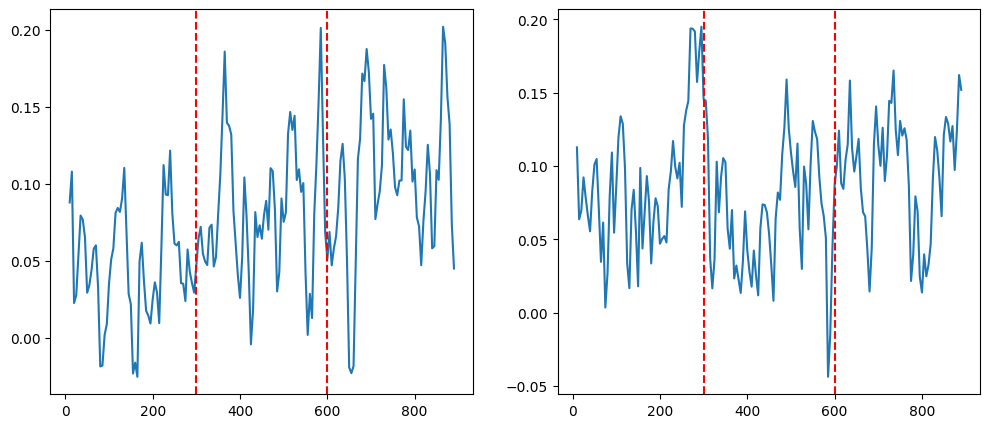

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(wincenters, np.mean( all_win_corrmat_active[:,133,:] , axis=-1 ), label='active')
ax[0].axvline(300, color='r', linestyle='--')
ax[0].axvline(600, color='r', linestyle='--')

ax[1].plot(wincenters, np.mean( all_win_corrmat_sham[:,133,:] , axis=-1 ), label='sham')
ax[1].axvline(300, color='r', linestyle='--')
ax[1].axvline(600, color='r', linestyle='--')

#plt.plot(wincenters, np.mean( all_win_corrmat_sham[:,133,:] , axis=-1 ), label='sham')

#fig, ax = plt.subplots(1,2, figsize=(10,5))
#ax[0].plot(wincenters, np.mean( all_win_corrmat_active , axis=(-2,-1) ), label='active')
#ax[1].plot(wincenters, np.mean(all_win_corrmat_sham, axis=(-2,-1)) , label='sham')

## Stimulus-locked responses

In [41]:
pre_stim = 5
post_stim = 60
#stim_onsets = np.array([0,60,120,180,240])+300
stim_onsets = np.array([0,60,120,180,240])+300
#stim_onsets = np.array([0])+300
all_responses = analyze_immediate_effects(time_series, stim_onsets, pre_stim=pre_stim, post_stim=post_stim, baseline_correct=True)
#x3_active.shape, bold_3d_active.shape

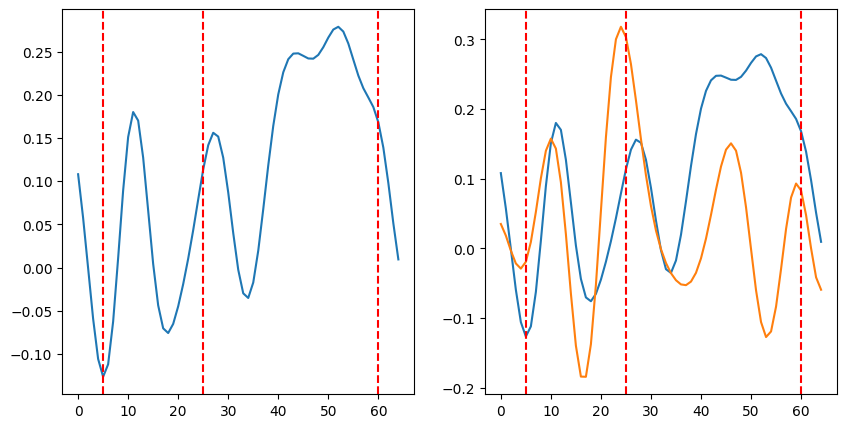

In [42]:
x3_active = np.zeros((len(all_responses['active']),all_responses['active'][0].shape[0],all_responses['active'][0].shape[1]))
x3_sham = np.zeros((len(all_responses['sham']),all_responses['sham'][0].shape[0],all_responses['sham'][0].shape[1]))

for i, x in enumerate(all_responses['active']):
    x3_active[i,:,:] = x

for i, x in enumerate(all_responses['sham']):
    x3_sham[i,:,:] = x

mu_active = np.mean(x3_active, axis=0)
mu_sham = np.mean(x3_sham, axis=0)

roi=133
#roi= 566 # 61, 710, 567

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(mu_sham[:, roi], label='sham')
ax[0].axvline(pre_stim, color='r', linestyle='--')
ax[0].axvline(pre_stim+20, color='r', linestyle='--')
ax[0].axvline(post_stim, color='r', linestyle='--')

ax[1].plot(mu_sham[:, roi], label='sham')
ax[1].plot(mu_active[:, roi], label='active')
ax[1].axvline(pre_stim, color='r', linestyle='--')
ax[1].axvline(pre_stim+20, color='r', linestyle='--')
ax[1].axvline(post_stim, color='r', linestyle='--')

In [43]:
all_responses['active'].shape
time_series['active'][0].shape, len(time_series['active'])

((900, 1024), 16)

In [44]:
# Fetch DiFuMo labels
difumo = datasets.fetch_atlas_difumo(dimension=1024)
labels = difumo.labels  # List of 1024 anatomical labels

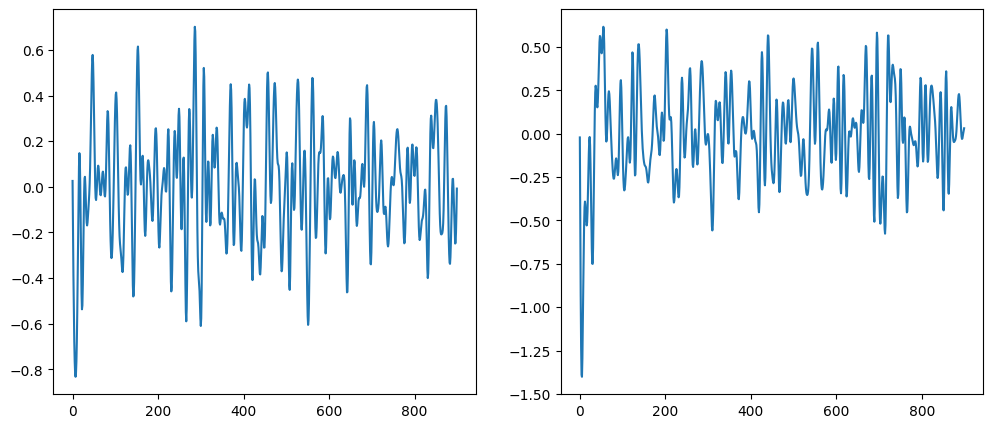

In [45]:
from scipy.signal import savgol_filter
roi = 133
mu_roi_bold_active = np.mean(bold_3d_active[:,:,roi], axis=0)
mu_roi_bold_sham = np.mean(bold_3d_sham[:,:,roi], axis=0)
smoothed_active = savgol_filter(mu_roi_bold_active, window_length=5, polyorder=3)
smoothed_sham = savgol_filter(mu_roi_bold_sham, window_length=5, polyorder=3)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(smoothed_sham, label='sham')
#ax[1].plot(smoothed_sham, label='sham')
ax[1].plot(smoothed_active, label='active')

In [7]:
def resample_mask_to_bold(mask_img, bold_reference):
    """
    Resample mask to match BOLD data space

    Parameters:
    -----------
    mask_img : Nifti1Image
        sgACC mask
    bold_reference : str or Nifti1Image
        Reference BOLD image or path

    Returns:
    --------
    resampled_mask : Nifti1Image
        Resampled mask matching BOLD space
    """
    from nilearn import image

    # Load reference if path provided
    if isinstance(bold_reference, str):
        bold_reference = image.load_img(bold_reference)

    # Resample mask to match BOLD
    resampled_mask = image.resample_to_img(
        mask_img,
        bold_reference,
        interpolation='nearest'  # Use nearest neighbor for binary masks
    )

    # Ensure binary
    mask_data = resampled_mask.get_fdata()
    mask_data = (mask_data > 0.5).astype(float)

    return image.new_img_like(resampled_mask, mask_data)

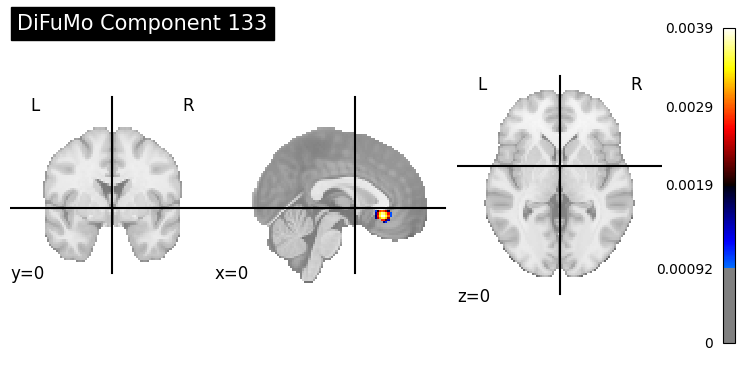

In [96]:
## Code to plot the sgACC mask
component_idx=133
component_img = image.index_img(difumo_atlas, component_idx)
threshold_percentile=10
# Threshold the map to show only highest weights
data = component_img.get_fdata()
threshold = np.percentile(data[data > 0], threshold_percentile)

# Create plot
display = plotting.plot_stat_map(
        component_img,
        threshold=threshold,
        title=f'DiFuMo Component {component_idx}',
        cut_coords=(0, 0, 0),  # Start at origin
        display_mode='ortho',
        colorbar=True
)